In [1]:
#| default_exp GP_regression

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

In [3]:
#| export
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup

In [4]:
#| export
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic, RBF
#from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
#from sklearn.pipeline import Pipeline

In [5]:
data_map = interactive.Widget()

In [6]:
data_map.display()

In [8]:
glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [9]:
glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'mid-point (ish)')

original xy [76.42832205667948, 35.746937189220425] 4326 maps to datacube (629145.576366352, 3956821.2096195645) EPSG:32643
original xy [76.42832205667948, 35.746937189220425] 4326 maps to datacube (629145.576366352, 3956821.2096195645) EPSG:32643
subset and load at  62.50 seconds


Let's take a look at the image pair velocity time series for the point we specified. You'll notice 

In [36]:
ds = swap_time_dim(glacier_point.datacube_point)

In [39]:
df = ds[['v','v_error','img1_numeric','img2_numeric']].to_dataframe()

In [55]:
df.head().index

Float64Index([2022.4027397260274, 2022.0246575342467, 2021.9095890410958,
               2022.704109589041, 2022.3342465753424],
             dtype='float64', name='time_numeric')

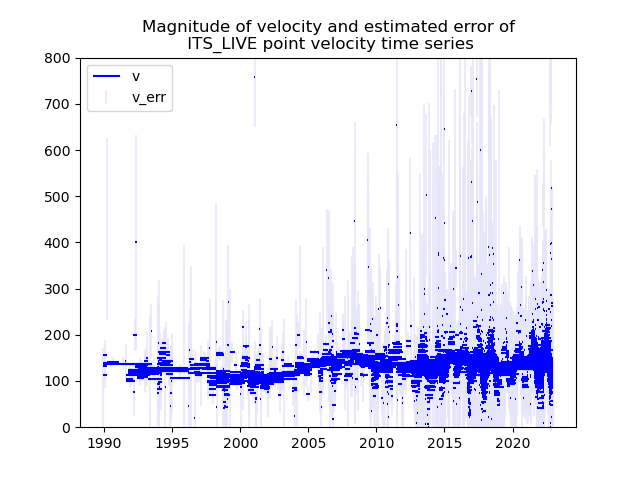

In [73]:
fig, ax = plt.subplots()

ax.errorbar(y=df['v'], yerr = df['v_error'], x = df.index,  color='lavender', alpha = 0.8, linestyle='None', label ='v_err')
ax.hlines(xmin = df['img1_numeric'], xmax = df['img2_numeric'],y = df['v'], color='blue', label='v')
ax.set_ylim(0,800)
ax.legend()
ax.set_title('Magnitude of velocity and estimated error of\n ITS_LIVE point velocity time series');

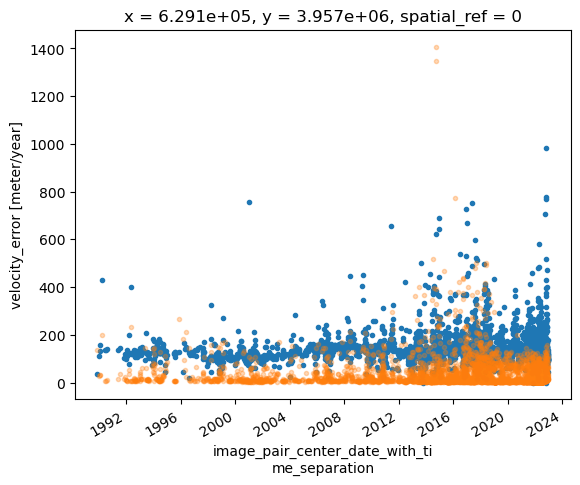

In [10]:
fig, ax = plt.subplots()
glacier_point.datacube_point.v.plot(ax=ax, linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=ax, linestyle='None', marker='o', alpha = 0.3, markersize=3);

This was just for one pixel. `Glacier_Point` also contains a 3x3 pixel cube surrounding the specified point to account for potential outlier estimates.

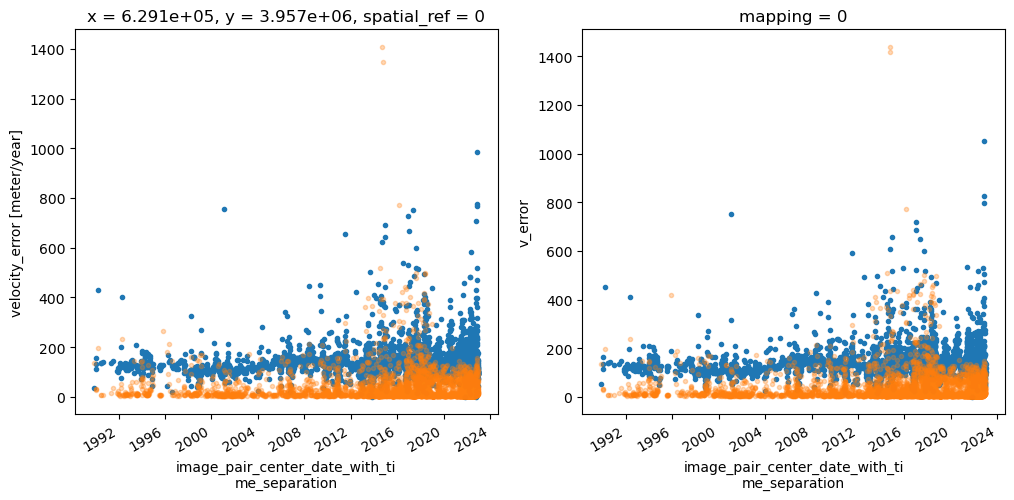

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
glacier_point.cube_around_point.v.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', markersize=3);
glacier_point.cube_around_point.v_error.median(dim=['x','y']).plot(ax=axs[1], linestyle='None', marker='o', alpha = 0.3, markersize=3);

glacier_point.datacube_point.v.plot(ax=axs[0], linestyle='None', marker='o', markersize=3);
glacier_point.datacube_point.v_error.plot(ax=axs[0], linestyle='None', marker='o', alpha = 0.3, markersize=3);

This comparison shows us that the trends we see in the single pixel plot are not too different from the pixels surrounding it. Good to know! 

Taking a look at this time series, we can see that there is interesting variability but also a fair amount of noise. This is where the regression methods become useful. 

Now we'll look at setting up the Gaussian Process model.

In [74]:
#| export

point_ls = [glacier_point]

In [75]:
#| export
def prepare_ds(point_obj):

    '''note: i think this should be in its own notebook because its a different procss/step
       keeping here for now just to get an example going
       '''
    ds = point_obj.cube_around_point

    ds_sub = ds.where(ds.img_separation >= 60., drop=True)

    return ds, ds_sub

In [76]:
#| export
def swap_time_dim(ds):
    ds['time_numeric'] = ds.mid_date.dt.year + ds.mid_date.dt.dayofyear / 365
    ds = ds.swap_dims({'mid_date':'time_numeric'})

    ds['img1_numeric'] = ds.acquisition_date_img1.dt.year + ds.acquisition_date_img1.dt.dayofyear / 365
    ds['img2_numeric'] = ds.acquisition_date_img2.dt.year + ds.acquisition_date_img2.dt.dayofyear / 365
    return ds

In [77]:
#| export
from sklearn.preprocessing import MinMaxScaler
import torch

class ModelInputs():
    '''this is a class to store model inputs for GP Regression. it is intended to store data for an individual temporal baseline category.
    '''
    def __init__(self, label, df, col, cutoffs):

        self.label = label
        self.df = df
        self.col = col
        self.cutoffs = cutoffs
        self.df_subset = self._filter_baselines()
        self.t_train, self.y_train, self.t_test, self.noise, self.scaled_y_train = self._organize_training_data()

    def _filter_baselines(self):
        df = self.df
        cutoffs = self.cutoffs
        df = df.dropna(subset=self.col)
        df_sub = df.loc[(df['img_separation'] >= cutoffs[0]) & (df['img_separation'] < cutoffs[1])]
        return df_sub

    def _organize_training_data(self):

        scaler = MinMaxScaler()
    
        t_train_np = self.df_subset.time_numeric.values
        y_train_np = self.df_subset[self.col].values
        model = scaler.fit(y_train_np.reshape(-1,1))
        scaled_y_train_np = model.transform(y_train_np.reshape(-1,1)).ravel()
    
        t_train_tensor = torch.Tensor(t_train_np)
        y_train_tensor = torch.Tensor(y_train_np)
        scaled_y_train_tensor = torch.Tensor(scaled_y_train_np)
    
        t_test_np = np.linspace(t_train_np.min(), t_train_np.max(), len(t_train_np))
        t_test_tensor = torch.Tensor(t_test_np)

        noise_tensor = torch.Tensor(self.df_subset['spatial_median_v_err'].values)
    
        
        return t_train_tensor, y_train_tensor, t_test_tensor, noise_tensor, scaled_y_train_tensor

In [78]:
#| export
def point_to_model_input(point_ls_obj, tb_category):

    point_ds, point_ds_sub = prepare_ds(point_ls_obj)

    #point_ds_sub = swap_time_dim(point_ds_sub)
    
    ds_new = swap_time_dim(point_ds_sub)
    ds_new['spatial_median_v'] = (('time_numeric'), ds_new.v.median(dim=['x','y']).data)
    ds_new['spatial_median_v_err'] = (('time_numeric'), ds_new.v_error.median(dim=['x','y']).data)
    df = ds_new[['mid_date','spatial_median_v','time_numeric','img_separation','spatial_median_v_err']].to_dataframe().reset_index().dropna(subset='spatial_median_v')

    mod_input = ModelInputs(point_ls_obj.label, df, 'spatial_median_v', tb_category)

    return mod_input

In [79]:
#| export 
class SKLearnModelPreds():
    def __init__(self, inputs, kernel):
        self.inputs = inputs
        self.kernel = kernel
        #self.priors = priors
        self.t_train = self.inputs.t_train.numpy().reshape(-1,1)
        self.y_train = self.inputs.y_train.numpy().reshape(-1,1)
        self.t_test = self.inputs.t_test.numpy().reshape(-1,1)
        self.gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer='fmin_l_bfgs_b')
        self.y_pred, self.sigma, self.rmse = self.run_model()

    def run_model(self):

        self.gp.fit(self.t_train, self.y_train)
        y_pred, sigma = self.gp.predict(self.t_test, return_std=True)
        rmse = np.sqrt(((y_pred - self.y_train)**2).mean())
        return y_pred, sigma, rmse

In [80]:
#| export
mod_input_ls = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], [0,600])
    mod_input_ls.append(mod_input)

In [81]:
#| export
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RBF
from sklearn.model_selection import GridSearchCV

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) + Matern(length_scale=1.5, length_scale_bounds=(0.0, 10.0), nu = 1.5) + ExpSineSquared(length_scale=1, periodicity=1, length_scale_bounds = (0,10), periodicity_bounds=(1e-3, 10.0)) + WhiteKernel(noise_level=2., noise_level_bounds = (1e-6,1e3))

mod_output_ls = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls[i], kernel)
    mod_output_ls.append(mod_output)

In [20]:
#| hide 
%matplotlib widget

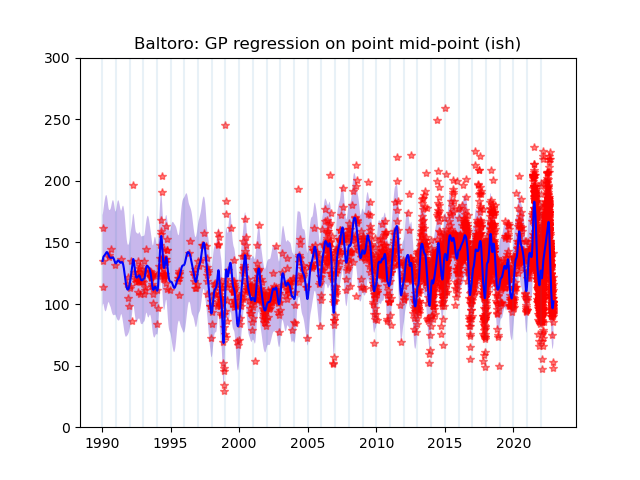

In [82]:
#| export
fig, ax = plt.subplots()

ax.plot(mod_output_ls[0].t_train, mod_output_ls[0].y_train, 'r*', alpha = 0.5)
ax.plot(mod_output_ls[0].t_test, mod_output_ls[0].y_pred, c='blue')
ax.fill_between(mod_output_ls[0].t_test.ravel(),
                          mod_output_ls[0].y_pred + 1.96 * mod_output_ls[0].sigma,
                          mod_output_ls[0].y_pred - 1.96 * mod_output_ls[0].sigma,
                          facecolor='mediumpurple',alpha = 0.5)
x_ls = np.arange(1990, 2023, 1)
    

ax.set_ylim(0,300)
ax.set_title(f'Baltoro: GP regression on point {point_ls[0].label}')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
for x in x_ls:
    ax.axvline(x = x, alpha=0.1);
    

In [43]:
# somewhere in this notebook a time sereis plot with horizontal bars corresponidng to temporal baseline should be added to convey different types of ice movement meaersurements